# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

>**Exercise 8.1:** Define needed transforms for training images and testing images.

In [2]:
## Exercise 8.1:

data_dir = './cat_dog/Cat_Dog_data' ## TODO: set correct path here

mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean_nums, std_nums)])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean_nums, std_nums)])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [3]:
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [4]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [5]:
import time

In [6]:
#device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for device in ['cpu','cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")
    
print("Best device: ",device)

Device = cpu; Time per batch: 1.217 seconds
Device = cuda; Time per batch: 0.008 seconds
Best device:  cuda


You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.

>**Exercise 8.2:** Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

## Tallennetun mallin voi ladata tämän jälkeen

In [9]:
## Exercise 8.2:
## TODO: Use a pretrained model to classify the cat and dog images

import time

train_loss, val_loss, accur = [], [], []
epochs = 2
since = time.time()
for i in range(epochs):
    model.to(device)
    print("Epoch {}/{}".format(i, epochs))
    print("-"*10) 
    running_loss = 0.0
    running_correct = 0
    validation_loss = 0
    batch = 0
    
    for images, labels in trainloader:
        batch += 1
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels_pred = model(images)
        _,pred = torch.max(labels_pred.data, 1)

        loss = criterion(labels_pred,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loss.append(running_loss/len(trainloader))
        running_correct += torch.sum(pred == labels.data)
        accuracy = running_correct/batch
        # Printataan joka 10. iteraation loss ja tarkkuus
        if batch%10 == 0:
            print("Batch {}, Train Loss:{:.4f}, Train accuracy:{:.4f}".format(
            batch, running_loss/batch, accuracy))

    else:
        print("Validation pass...")
        # validation pass
        with torch.no_grad():
            model.eval()
            model.to(device)
            
            for x, y in trainloader:
                img = x.to(device)
                labels = y.to(device)
                logps = model(img)
                batch_loss = criterion(logps, labels)
                
                validation_loss += batch_loss.item()
                ps = torch.exp(model(img))
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor))
            # Validation loss & accuracy
            accur.append(accuracy.item()*100)
            print(f'Batch {batch} Validation loss: {validation_loss/len(trainloader)}%, Accuracy: {accuracy.item()*100}%')
            val_loss.append(validation_loss/len(trainloader))
        
        epoch_loss = running_loss/len(trainloader)
        epoch_correct = 100*running_correct/len(trainloader)
        print("Total loss of epoch {}: Loss:{:.4f}, Correct:{:.4f}".format(i, epoch_loss, epoch_correct))

        model.train()
        
now_time = time.time() - since
print("Training time is:{:.0f}m {:.0f}s".format(now_time//60, now_time%60))

Epoch 0/2
----------
Batch 10, Train Loss:0.1397, Train accuracy:60.0000
Batch 20, Train Loss:0.1453, Train accuracy:59.0000
Batch 30, Train Loss:0.1420, Train accuracy:59.0000
Batch 40, Train Loss:0.1504, Train accuracy:59.0000
Batch 50, Train Loss:0.1539, Train accuracy:59.0000
Batch 60, Train Loss:0.1565, Train accuracy:59.0000
Batch 70, Train Loss:0.1563, Train accuracy:59.0000
Batch 80, Train Loss:0.1524, Train accuracy:59.0000
Batch 90, Train Loss:0.1512, Train accuracy:59.0000
Batch 100, Train Loss:0.1464, Train accuracy:59.0000
Batch 110, Train Loss:0.1439, Train accuracy:60.0000
Batch 120, Train Loss:0.1411, Train accuracy:60.0000
Batch 130, Train Loss:0.1418, Train accuracy:60.0000
Batch 140, Train Loss:0.1411, Train accuracy:60.0000
Batch 150, Train Loss:0.1447, Train accuracy:60.0000
Batch 160, Train Loss:0.1444, Train accuracy:60.0000
Batch 170, Train Loss:0.1443, Train accuracy:60.0000
Batch 180, Train Loss:0.1450, Train accuracy:60.0000
Batch 190, Train Loss:0.1470, Trai

#### Jännästi huomaa että treenaus vaiheessa, malli on joka kuvan kohdalla vain 60% varma kumpi se on.

## Loss vs. validation vs. accuracy
### Teen vähän kikkailuja, koska otin talteen train_lossin väärissä kohdissa:
Muutan listan listojen listaksi epochien määrän mukaan ja otan listoista keskiarvon.

In [24]:
import numpy as np

n = int(round(len(train_loss)/epochs))
print(n)
lst = train_loss
A = [lst[i:i + n] for i in range(0, len(lst), n)]
print(len(A[0]))
B = np.array(A)
converted_list = np.mean(B, axis=1)
converted_list

352
352


array([0.09551178, 0.07527352, 0.07234284, 0.06813296, 0.06307078])

1760
5


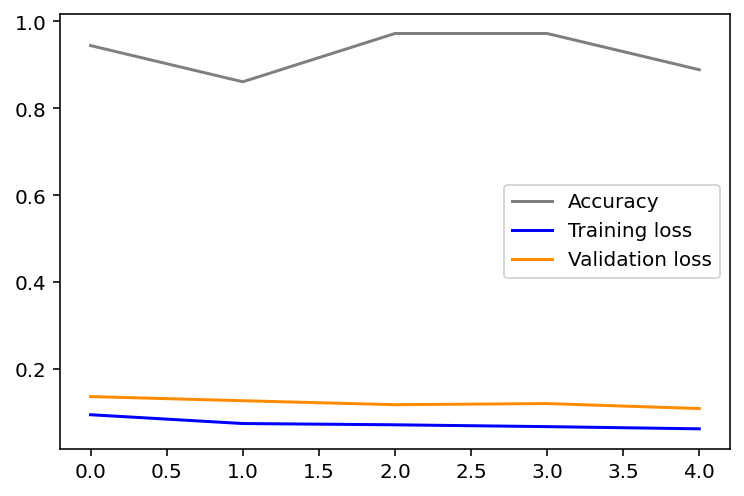

In [26]:
## Exercise 8.3:
## TODO: Print 8 pictures of errors in dog/cat -classification. 

print(len(train_loss))
print(len(val_loss))

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot([i for i in range(epochs)], [j/100 for j in accur], color="black", label="Accuracy", alpha=0.5)
plt.plot([i for i in range(epochs)], converted_list, color="b", label="Training loss")
plt.plot([i for i in range(epochs)], val_loss, color="darkorange", label="Validation loss")
plt.legend()

### Kuvassa ajettu 5:llä epochilla

---

But still the network makes mistakes... 

>**Exercise 8.3:** Print 8 pictures of errors in dog/cat -classification. 


## Tallenetaan ja ladataan malli

In [10]:
file = "part8_network.pth"
torch.save(model.state_dict(), file)
print("Model saved as '{}'".format(file))

Model saved as 'part8_network.pth'


In [11]:
state_dict = torch.load('part8_network.pth')
#print(state_dict.keys())

In [12]:
model.load_state_dict(state_dict)

<All keys matched successfully>

## Iteroin testloaderin läpi kunnes saan 8 kuvaa jossa labelit ja ennustetut labelit eivät ole samat, jolloin kuva, väärä label ja väär ennustettu label lisätään listoihin

In [20]:
loop = 0
errorimages = []
errorlabels = []
predlabels = []
while len(errorimages) != 8:
    testimages, testlabels = next(iter(testloader))
    testimages, testlabels = testimages.to(device), testlabels.to(device)
    outputs = model(testimages)
    
    _, predicted = torch.max(outputs.data, 1)

    if testlabels[0] != predicted[0]:
        print("\rError found at index ", loop)
        errorimages.append(testimages[0])
        errorlabels.append(testlabels[0])
        predlabels.append(predicted[0])
        loop +=1
        print("\r",loop, end='')
    else:
        loop += 1
        print("\r",loop, end='')


Error found at index  139
Error found at index  201
Error found at index  230
Error found at index  317
Error found at index  376
Error found at index  520
Error found at index  527
Error found at index  547
 548

#### Näin saan sitten ulos luokan nimen

In [23]:
classes = test_data.classes

for i in range(8):
    print("\nReal label",classes[errorlabels[i]])
    print("Pred label",classes[predlabels[i]])


Real label dog
Pred label cat

Real label dog
Pred label cat

Real label dog
Pred label cat

Real label dog
Pred label cat

Real label cat
Pred label dog

Real label dog
Pred label cat

Real label cat
Pred label dog

Real label dog
Pred label cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


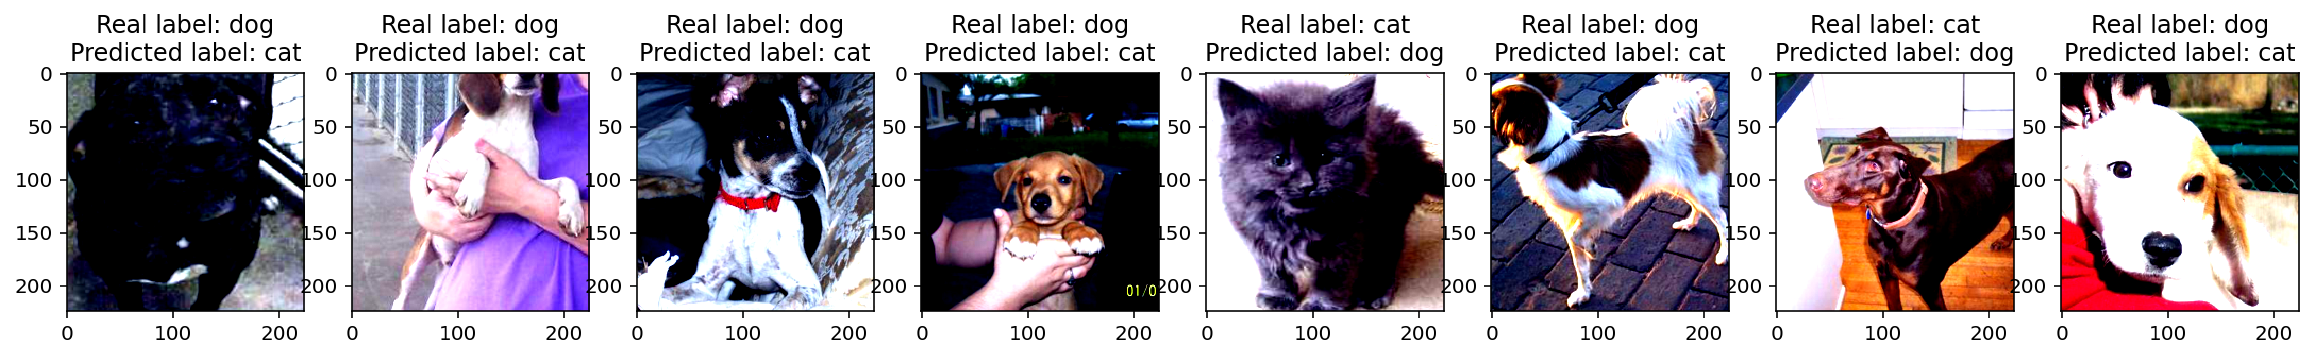

In [62]:
fig, axes = plt.subplots(figsize=(20,4), ncols=8)
for i in range(8):
    # Unnormalize so the pictures don't look weird (like too dark or saturated)
    img = testimages / 2 + 0.5
    # can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
    img = img.to('cpu')
    ax = axes[i]
    img = img[i].numpy().transpose((1, 2, 0))
    ax.imshow(img, interpolation='nearest')

    ax.set_title("Real label: {}\nPredicted label: {}".format(classes[errorlabels[i]],classes[predlabels[i]]))

#### disclaimer: Joskus listaan näköjään eksyy pari oikeaa labelia jotka on väärin kuvissa. Toimii 90% ajasta joten yolo lmao

## Reflection

Answer briefly following questions (in English or Finnish):
- What is CUDA?
- Why GPU is faster than CPU?
- How many pre-trained image network can you find from torchvision models?
- What kind of pictures network mislabels? Are those still easy for a human to classify?

- CUDA on Nvidian näytönohjaimissa käytettävä API, jolla voidaan hyödyntää näytönohjaimien rinnakkaislaskentaa.
- GPU:issa on potentiaalisesti tuhansia ytimiä, kun taas CPU:issa 4,8, 16 tai jossakin harvoissa 64. Yksi ydin laskee yhden koneoppimislaskun, joten totta kai, mitä enempi ytimiä, sitä enempi voidaan ajaa rinnakkain.
- 29 https://pytorch.org/vision/0.8/models.htmlhttps://pytorch.org/vision/0.8/models.html
- Kuvat näyttävät olevan ihan normaaleja. Jotkin kuvat ovat sellaisia mitä on aika vaikea arvata kumpi elukka se on jos ei esim. näy päätä. Mutta joillakin kuville on ilmeisesti myös väärä label. Tosin se on varmaan omasta päästä vika.

Tälläisiä kuvia tulee eteen nii ei sitä nyt tiedä kumpaan luottaa...

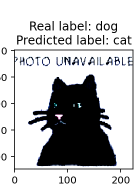

# Testailut

In [ ]:
train_loss, val_loss, accur = [], [], []
n_epochs = 10
for epoch in range(n_epochs):
    since = time.time()
    print("Epoch {}/{}".format(epoch, n_epochs))
    print("-"*10) 
    running_loss = 0.0
    running_correct = 0
    batch = 0
    for data in trainloader:
        batch += 1
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels_pred = model(images)
        _,pred = torch.max(labels_pred.data, 1)

        loss = criterion(labels_pred,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_correct += torch.sum(pred == labels.data)
        accuracy = running_correct/batch
        accur.append(accuracy)
        if batch%10 == 0:
            print("Batch {}, Train Loss:{:.4f}, Train accuracy:{:.4f}".format(
            batch, running_loss/batch, accuracy))

    epoch_loss = running_loss/len(trainloader)
    train_loss.append(epoch_loss)
    epoch_correct = 100*running_correct/len(trainloader)
    val_loss.append(epoch_correct)

    print("Epoch {:.1f} Train Loss:{:.4f}, Correct:{:.4f}".format(epoch, epoch_loss, epoch_correct))
now_time = time.time() - since
print("Training time is:{:.0f}m {:.0f}s".format(now_time//60, now_time%60))

In [342]:
correct = 0
test_total = 0

images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)

outputs = model(images)

_, predicted = torch.max(outputs.data, 1)
test_total += labels.size(0)
labels = labels.type_as(predicted)

correct += (predicted == labels[0]).sum()
print('Accuracy of the network on all the test images: %d %%' % (100 * correct / test_total))

Accuracy of the network on all the test images: 51 %


In [55]:
errorimages = []
errorlabels = []
predlabels = []
while len(errorimages) != 8:
    images, labels = next(iter(testloader))
    images, labels = images.to(device),labels.to(device)
    # Get the class probabilities
    ps = torch.exp(model(images))
    # Find the most likely class
    top_p, top_class = ps.topk(1, dim=1)

    equals = top_class == labels.view(*top_class.shape)
    accuracy = torch.mean(equals.type(torch.FloatTensor))
    print(equals)
    print(accuracy)

tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True

In [60]:
images, labels = next(iter(testloader))
images, labels = images.to(device),labels.to(device)
# Get the class probabilities
ps = torch.exp(model(images))
# Find the most likely class
top_p, top_class = ps.topk(1, dim=1)

equals = top_class == labels.view(*top_class.shape)
accuracy = torch.mean(equals.type(torch.FloatTensor))

(equals == False).nonzero(as_tuple=True)[0]

tensor([52, 59], device='cuda:0')

In [11]:
classes = test_data.classes

testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)
images, labels = next(iter(testloader))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

NameError: name 'torchvision' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


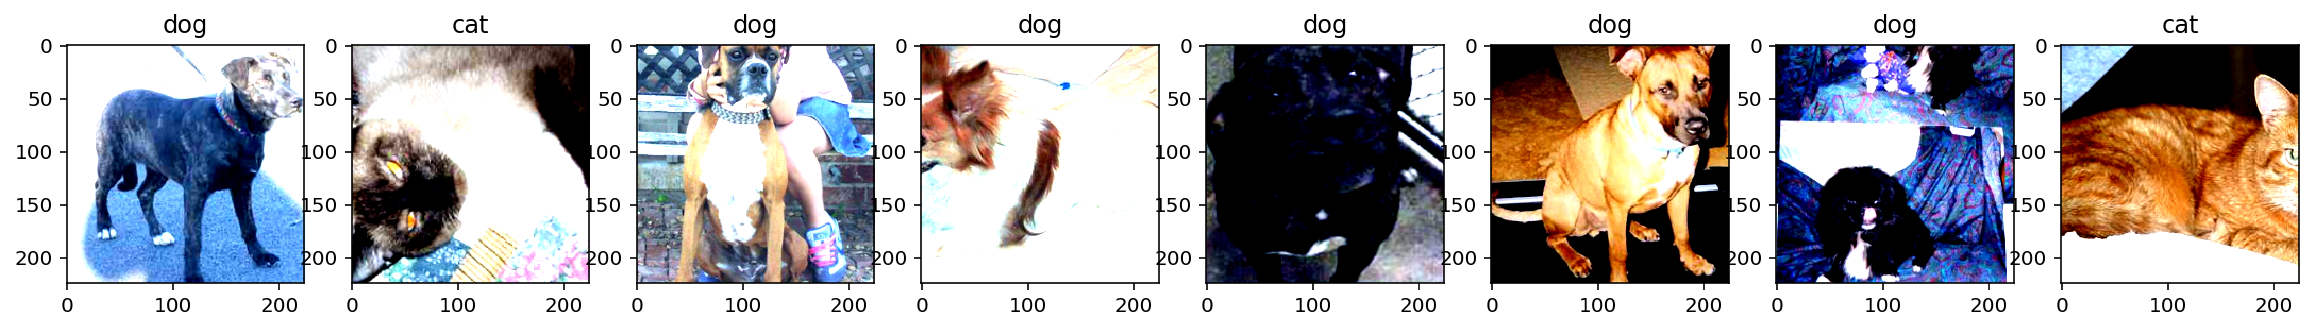

In [12]:
import numpy as np
import torchvision

classes = test_data.classes

testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)
images, labels = next(iter(testloader))

fig, axes = plt.subplots(figsize=(20,4), ncols=8)
for ii in range(8):
    # Unnormalize so the pictures don't look weird (like too dark or saturated)
    images = images / 2 + 0.5
    ax = axes[ii]
    img = img[ii].numpy().transpose((1, 2, 0))
    ax.imshow(img, interpolation='nearest')
    ax.set_title(classes[labels[ii]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


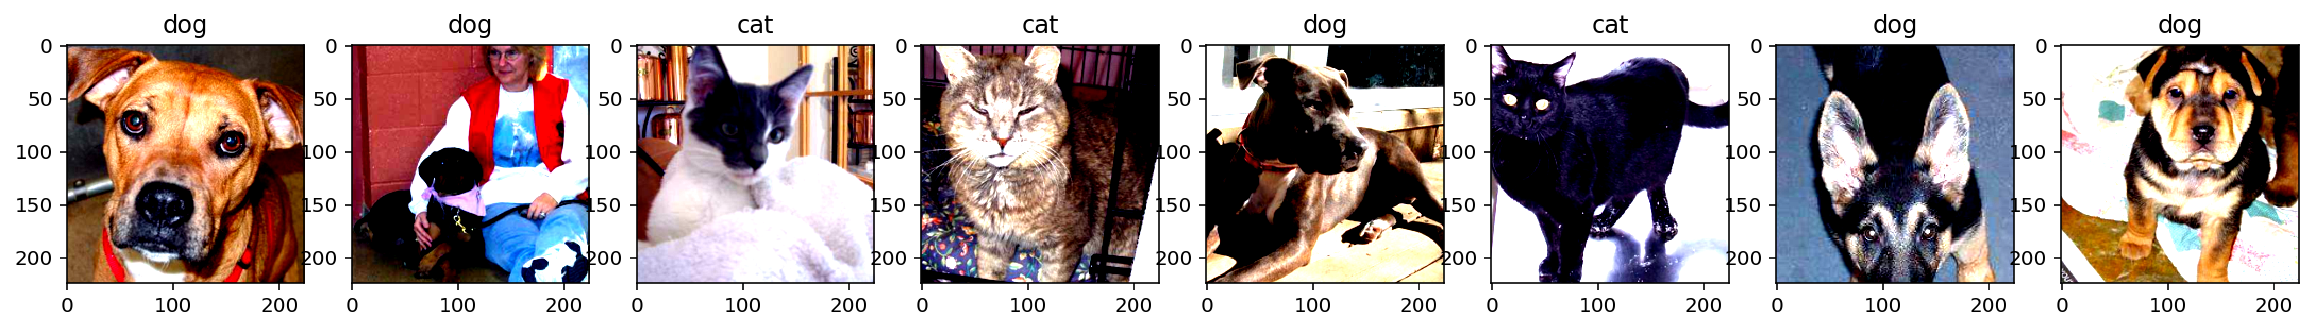

In [166]:
classes = test_data.classes

testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)
images, labels = next(iter(testloader))

fig, axes = plt.subplots(figsize=(20,4), ncols=8)
for ii in range(8):
    # Unnormalize so the pictures don't look weird (like too dark or saturated)
    img = images / 2 + 0.5
    ax = axes[ii]
    img = img[ii].numpy().transpose((1, 2, 0))
    ax.imshow(img, interpolation='nearest')
    ax.set_title(classes[labels[ii]])

In [139]:
images, labels = next(iter(testloader))

img = images[0].view(1, 1, 224**2*3)
output = model(img)
# Output of the network are log-probabilities
ps = torch.exp(model(img))
helper.view_classify(img.view(1, 224, 224), ps)
print("Label:", labels[0].item())

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64 3 7 7, but got 3-dimensional input of size [1, 1, 150528] instead

In [237]:
len(errorimages)

8

In [222]:
lst = [g for g in range(0,8)]
for i,j in zip(errorimages,lst):
    ax = axes[j]
    i = i.to('cpu')
    img = i / 2 + 0.5
    img = img[j].numpy().transpose((1, 2, 0))
    ax.imshow(img, interpolation='nearest')
    ax.set_title("Real label: {}\nPredicted label: {}".format(classes[errorlabels[j]], classes[predlabels[j]]))

ValueError: axes don't match array

In [122]:
import helper

model.to('cpu')
# Test out your network!
model.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()
print(images.shape)
img = images[0]
print(img.shape)
# Convert 2D image to 1D vector
img = img.view(1,1, 224**2*3)
img = img.unsqueeze_(3)
print(img.shape)
#print(img)
# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 224, 224), ps, version='Fashion')

torch.Size([16, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 150528, 1])


RuntimeError: Given groups=1, weight of size 64 3 7 7, expected input[1, 1, 150528, 1] to have 3 channels, but got 1 channels instead

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0, device='cuda:0')
tensor(0, device='cuda:0')


IndexError: index 8 is out of bounds for axis 0 with size 8

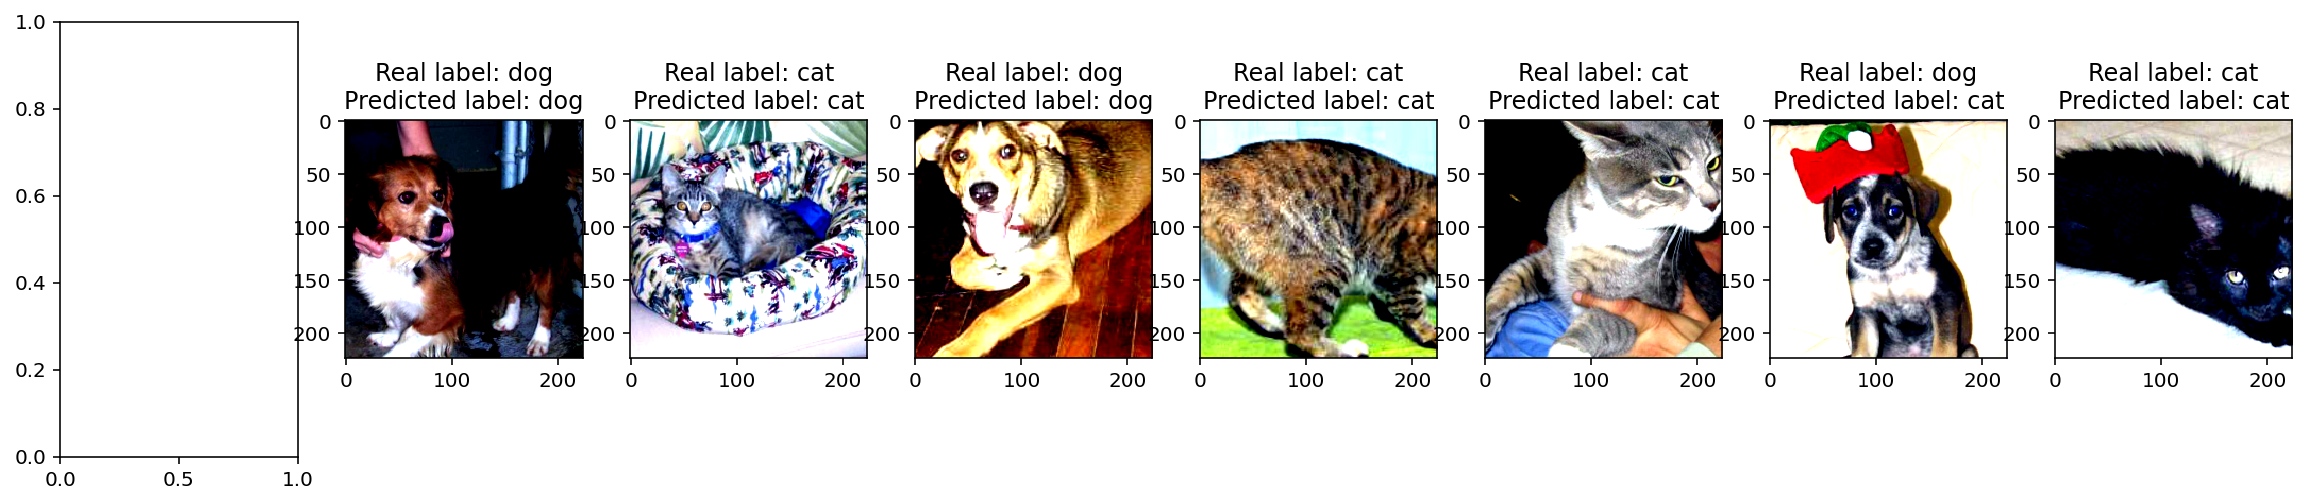

In [122]:
correct = 0
test_total = 0

fig, axes = plt.subplots(figsize=(20,4), ncols=8)
loop = 0
while loop < 8:
    for data in testloader:
        loop += 1
        testimages, testlabels = data
        testimages, testlabels = testimages.to(device), testlabels.to(device)
        outputs = model(testimages)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        labels = labels.type_as(predicted)

        img = testimages / 2 + 0.5
        # can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
        img = img.to('cpu')
        ax = axes[loop]
        img = img[loop].numpy().transpose((1, 2, 0))
        ax.imshow(img, interpolation='nearest')
        print(testlabels[loop])
        print(predicted[loop])

        ax.set_title("Real label: {}\nPredicted label: {}".format(classes[testlabels[loop]], classes[predicted[loop]]))

0


ValueError: axes don't match array

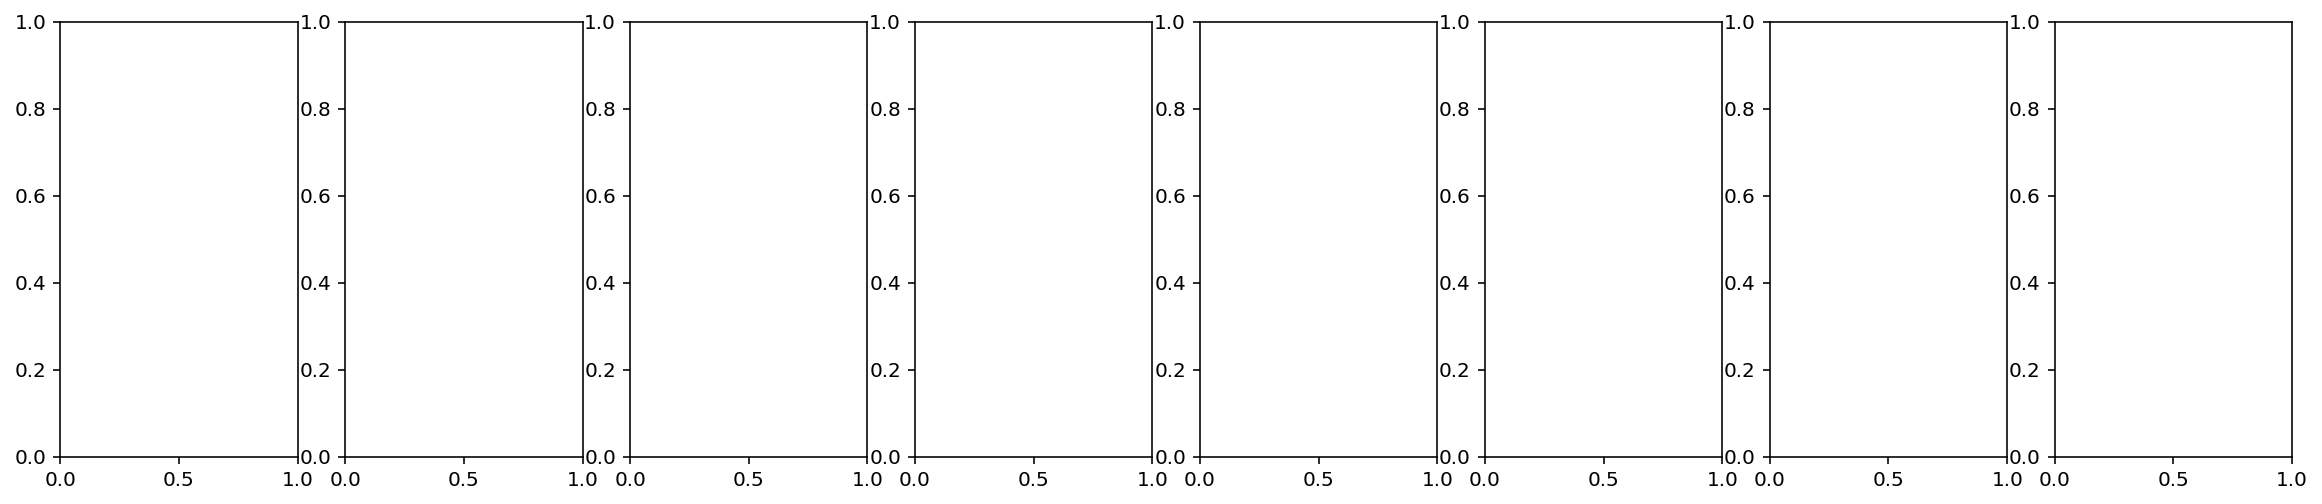

In [203]:
loop = 0

fig, axes = plt.subplots(figsize=(20,4), ncols=8)
while loop < 8:
    for i,j,g in zip(errorimages, errorlabels, predlabels):
        print(loop)
        ax = axes[loop]
        i = i.to('cpu')
        img = i / 2 + 0.5
        img = img[loop].numpy().transpose((1, 2, 0))
        ax.imshow(img, interpolation='nearest')
        print(errorlabels[g])
        ax.set_title("Real label: {}\nPredicted label: {}".format(classes[errorlabels[j]], classes[predlabels[g]]))
        loop += 1